# Model Evaluations

This notebook is made to collate all the trained models wth differing base models  
and perform metrics calculation with common test data

In [1]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, precision_recall_curve
import seaborn as sns
import tensorflow as tf
import numpy as np
import os
import PIL
import PIL.Image
import random
import matplotlib.pyplot as plt
sns.set()

## Load models
Model1 : VGG16  
Model2 : MobileNet  
Model3 : ResNet50V2  
Model4 : DenseNet121  

Load model 1 with VGG16 base model

In [2]:
model_1 = tf.keras.models.load_model('best_models/model_1_vgg/best_model.ckpt')

Load model 2 with MobileNet base model

In [3]:
model_2 = tf.keras.models.load_model('best_models/model_2_mobilenet/best_model.ckpt')

Load model 3 with ResNet50V2 base model

In [4]:
model_3 = tf.keras.models.load_model('best_models/model_3_resnet/best_model.ckpt')

Load model 4 with DenseNet121 base model

In [5]:
model_4 = tf.keras.models.load_model('best_models/model_4_densenet/best_model.ckpt')

In [6]:
model = [model_1, model_2, model_3, model_4]

## Generating the test data

Function definition for deconstruct dataset

In [7]:
def view_generator_data(gen, n):
    data = [next(gen) for _ in range(n)]
    data = list(zip(*data))
    X, y = data
    X = np.concatenate(X, axis=0)
    y = np.concatenate(y, axis=0)
    return X, y

def view_images(X, y, n=None):
    n = n or len(X)
    for i in range(n):
        plt.imshow(X[i])
        plt.grid(None)
        plt.show()
        print('Label: ', y[i])

#### Load the dataset

In [8]:
TEST_LOC_LIGHT= "../../datasets/sat_images/test"
IMG_SIZE = (128,128)
classes = {'no_damage':0, 'damage': 1,}

test_idg = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255)

test_gen= test_idg.flow_from_directory(TEST_LOC_LIGHT,IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb',   shuffle=False,
                                         batch_size=1
                                        )

Found 2000 images belonging to 2 classes.


#### Predictions

In [9]:
test_X, test_y = view_generator_data(test_gen, test_gen.n)

In [10]:
y_pred1 = model_1.predict(test_X)
y_pred1.reshape(test_gen.n,)

array([0.9002695 , 0.26613486, 0.21167283, ..., 0.57526004, 0.94966906,
       0.96302253], dtype=float32)

In [11]:
y_pred2 = model_2.predict(test_X)
y_pred2.reshape(test_gen.n,)

array([0.11440662, 0.01205231, 0.00194107, ..., 0.23489071, 0.6277836 ,
       0.88404393], dtype=float32)

In [12]:
y_pred3 = model_3.predict(test_X)
y_pred3.reshape(test_gen.n,)

array([7.3592804e-02, 1.3506526e-04, 3.1329785e-02, ..., 8.8520908e-01,
       6.6417342e-01, 8.7481278e-01], dtype=float32)

In [13]:
y_pred4 = model_4.predict(test_X)
y_pred4.reshape(test_gen.n,)

array([0.05981935, 0.07158179, 0.10302784, ..., 0.77756214, 0.45931482,
       0.49559692], dtype=float32)

In [14]:
y_pred = [y_pred1, y_pred2, y_pred3, y_pred4]

#### ROC Area under the Curve Scores

In [15]:
modelNames = ["VGG16", "MobileNet", "ResNet50V2", "DenseNet121"]
for idx, pred in enumerate(y_pred):
    print("ROC AUC score for ",modelNames[idx],":",roc_auc_score(test_y, pred))

ROC AUC score for  VGG16 : 0.9477720000000001
ROC AUC score for  MobileNet : 0.967465
ROC AUC score for  ResNet50V2 : 0.9796729999999999
ROC AUC score for  DenseNet121 : 0.9759479999999999


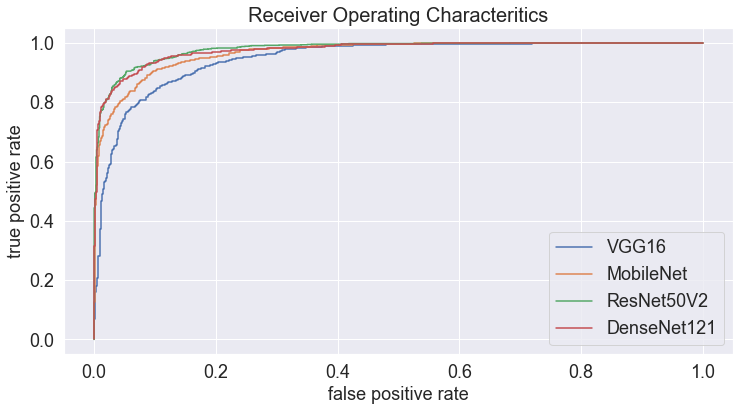

In [58]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(12,6))
for pred in y_pred:
    fpr, tpr, thres = roc_curve(test_y, pred, pos_label=1)
    plt.plot(fpr, tpr,)
plt.legend(modelNames, fontsize=18)
plt.title("Receiver Operating Characteritics", fontsize = 20)
plt.xlabel("false positive rate", fontsize = 18)
plt.ylabel("true positive rate",fontsize = 18)
plt.xticks(fontsize=18)
plt.yticks(fontsize =18)
plt.savefig('ROC.jpeg', bbox_inches='tight')
plt.show()

From these results, the ResNet50V2 show better classification performance for the positive class followed closely by DenseNet121

#### Precision Recall Curves

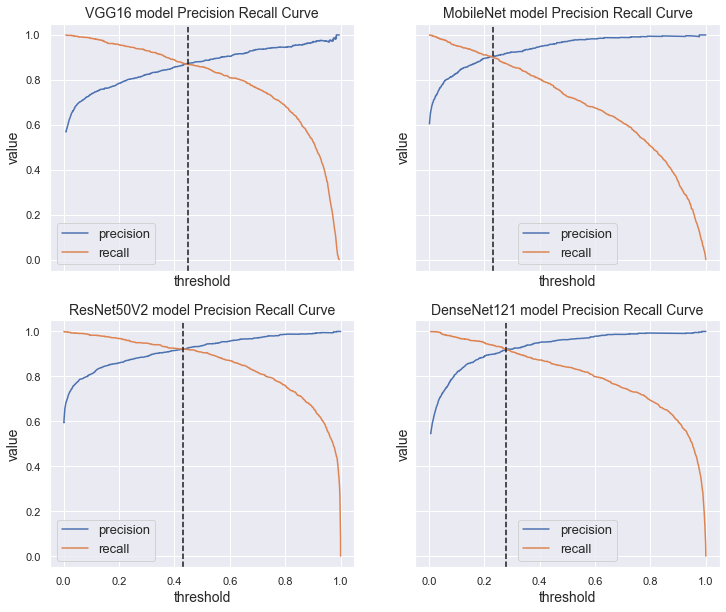

In [33]:

fig,ax = plt.subplots(figsize=(12,10), ncols=2, nrows=2, sharex=True,sharey=True)
thresholds=[0.45, 0.23, 0.43, 0.28]
for idx,pred in enumerate(y_pred):
    pr, r, thr = precision_recall_curve(test_y, pred)
    ax[int(idx/2)][idx%2].plot(thr, pr[:-1])
    ax[int(idx/2)][idx%2].plot(thr, r[:-1])
    ax[int(idx/2)][idx%2].set_xlabel('threshold', fontsize = 14)
    ax[int(idx/2)][idx%2].set_ylabel('value', fontsize = 14)
    ax[int(idx/2)][idx%2].axvline(x=thresholds[idx], color='k', linestyle='--')
    ax[int(idx/2)][idx%2].legend(["precision", 'recall'], fontsize = 13)
    ax[int(idx/2)][idx%2].set_title(modelNames[idx]+" model Precision Recall Curve", fontsize = 14)
fig.savefig('P-RCurve.jpeg', bbox_inches='tight')

From the above figure, we derive the threshold values for where the precision and recall curves intersect  
0.45, 0.23, 0.43 and 0.28

In [18]:
thresholds

[0.45, 0.23, 0.43, 0.28]

#### Accuracy Scores

In [19]:
for idx, pred in enumerate(y_pred):
    print("Accuracy score for ",modelNames[idx],":",accuracy_score(test_y > thresholds[idx], pred > thresholds[idx]))

Accuracy score for  VGG16 : 0.8715
Accuracy score for  MobileNet : 0.9035
Accuracy score for  ResNet50V2 : 0.9215
Accuracy score for  DenseNet121 : 0.9185


#### Confusion Matrices

VGG16  Classification Report: 
               precision    recall  f1-score   support

       False       0.87      0.88      0.87      1000
        True       0.87      0.87      0.87      1000

    accuracy                           0.87      2000
   macro avg       0.87      0.87      0.87      2000
weighted avg       0.87      0.87      0.87      2000



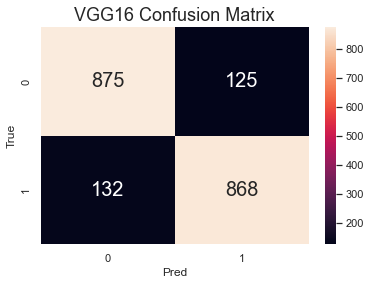

MobileNet  Classification Report: 
               precision    recall  f1-score   support

       False       0.90      0.90      0.90      1000
        True       0.90      0.90      0.90      1000

    accuracy                           0.90      2000
   macro avg       0.90      0.90      0.90      2000
weighted avg       0.90      0.90      0.90      2000



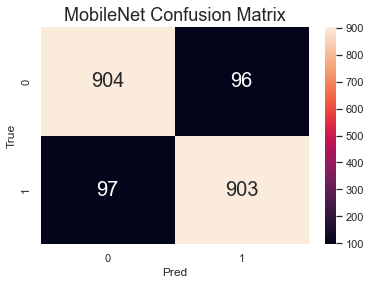

ResNet50V2  Classification Report: 
               precision    recall  f1-score   support

       False       0.92      0.92      0.92      1000
        True       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



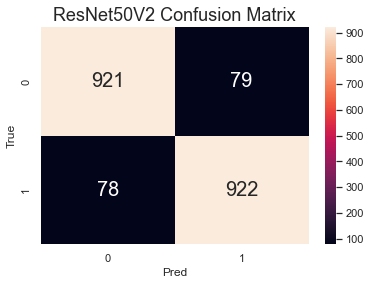

DenseNet121  Classification Report: 
               precision    recall  f1-score   support

       False       0.92      0.92      0.92      1000
        True       0.92      0.92      0.92      1000

    accuracy                           0.92      2000
   macro avg       0.92      0.92      0.92      2000
weighted avg       0.92      0.92      0.92      2000



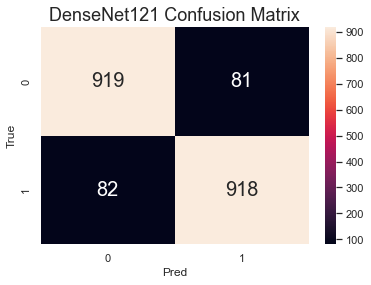

In [82]:
offset = 0
threshold = [x+offset for x in thresholds]
for idx,pred in enumerate(y_pred):
    print(modelNames[idx], " Classification Report: \n",classification_report(test_y>threshold[idx], pred > threshold[idx]))
    cm = confusion_matrix(test_y>threshold[idx], pred > threshold[idx])
    sns.heatmap(cm, annot=True, fmt="g", annot_kws={"size": 20})
    plt.title(modelNames[idx]+" Confusion Matrix", fontsize=18)
    plt.ylabel('True')
    plt.xlabel('Pred')
    plt.savefig('Matrix'+str(idx)+'.jpeg')
    plt.show()
    

### ResNet50V2 exhibits a more stable performance when adjusting threshold value to increase target Positive Recall.

#### Test the ResNet Model with the unbalanced test set
Define a test_model method to generate metrics visualization

In [100]:
def test_model(model, gen, thr, mode, n=None):
    n = n or gen.n
    if mode == 'rand':
        test_x, test_y = view_generator_data_rand(gen, n)
    else:
        test_x, test_y = view_generator_data(gen, n)
    y_pred = model.predict(test_x)
    y_pred.reshape(gen.n,)
    cm = confusion_matrix(test_y>thr,y_pred>thr)
    print("Classification Report: \n")
    print(classification_report(test_y>thr,y_pred>thr))
    print("Accuracy Score: \n",accuracy_score(test_y>thr,y_pred>thr))
    fig, ax = plt.subplots(figsize=(10,6))
    ax = sns.heatmap(cm,annot=True, fmt="g",  annot_kws={"size": 20})
    plt.title('Heatmap from confusion matrix', fontsize = 24)
    plt.ylabel("Test", fontsize = 18)
    plt.xlabel("Prediction",  fontsize = 18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize =18)
    plt.show()


Load unbalanced test data

In [93]:
TEST_LOC ="../../datasets/sat_images/test_another"
test_gen2= test_idg.flow_from_directory(TEST_LOC,IMG_SIZE,
                                         class_mode='binary', classes=classes,
                                         color_mode='rgb',   shuffle=False,
                                         batch_size=1
                                        )

Found 9000 images belonging to 2 classes.


#### Visualizing Metrics for the ResNet model with threshold value = 0.21

Classification Report: 

              precision    recall  f1-score   support

       False       0.76      0.84      0.79      1000
        True       0.98      0.97      0.97      8000

    accuracy                           0.95      9000
   macro avg       0.87      0.90      0.88      9000
weighted avg       0.95      0.95      0.95      9000

Accuracy Score: 
 0.9518888888888889


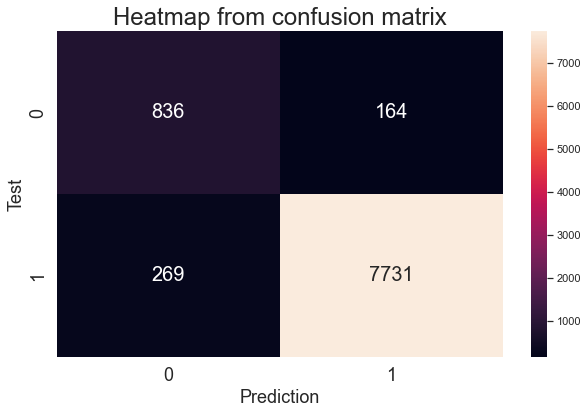

In [101]:
#Best Model is ResNet50V2
resnet_thr = thresholds[2]-0.22
test_model(model_3, test_gen2,resnet_thr,'')
